In [52]:
library(ggplot2)
library(gridExtra)
library(ggcorrplot)
library(NbClust)
library(fpc)
library(cluster)
library(factoextra)
library(purrr)
library(stats)

## Data

In [18]:
# Dataset from kaggle (https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python?resource=download)
mall_customers <- read.csv("Mall_Customers.csv", header = TRUE, sep = ",")

### Variables in the dataset:
- Customer ID
- Gender
- Age
- Annual income (k$)
- Spending score 

In [19]:
# simplify column names
colnames(mall_customers)[4] <- "Annual_income"
colnames(mall_customers)[5] <- "Spending_score"

In [20]:
# Dataset structure and characteristics
str(mall_customers)
summary(mall_customers)

'data.frame':	200 obs. of  5 variables:
 $ CustomerID    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Gender        : chr  "Male" "Male" "Female" "Female" ...
 $ Age           : int  19 21 20 23 31 22 35 23 64 30 ...
 $ Annual_income : int  15 15 16 16 17 17 18 18 19 19 ...
 $ Spending_score: int  39 81 6 77 40 76 6 94 3 72 ...


   CustomerID        Gender               Age        Annual_income   
 Min.   :  1.00   Length:200         Min.   :18.00   Min.   : 15.00  
 1st Qu.: 50.75   Class :character   1st Qu.:28.75   1st Qu.: 41.50  
 Median :100.50   Mode  :character   Median :36.00   Median : 61.50  
 Mean   :100.50                      Mean   :38.85   Mean   : 60.56  
 3rd Qu.:150.25                      3rd Qu.:49.00   3rd Qu.: 78.00  
 Max.   :200.00                      Max.   :70.00   Max.   :137.00  
 Spending_score 
 Min.   : 1.00  
 1st Qu.:34.75  
 Median :50.00  
 Mean   :50.20  
 3rd Qu.:73.00  
 Max.   :99.00  

In [21]:
# remove the ID and gender from the clustering data
clust_data = mall_customers[,-c(1,2)]

## Exploratory data analysis

In [22]:
# Histograms for variables
p1 <- ggplot(clust_data, aes(x=Age)) + geom_histogram(bins=20) + ggtitle('Age')
p2 <- ggplot(clust_data, aes(x=Annual_income)) + geom_histogram(bins=20) + ggtitle('Annual income (k$)')
p3 <- ggplot(clust_data, aes(x=Spending_score)) + geom_histogram(bins=20) + ggtitle('Spending score')

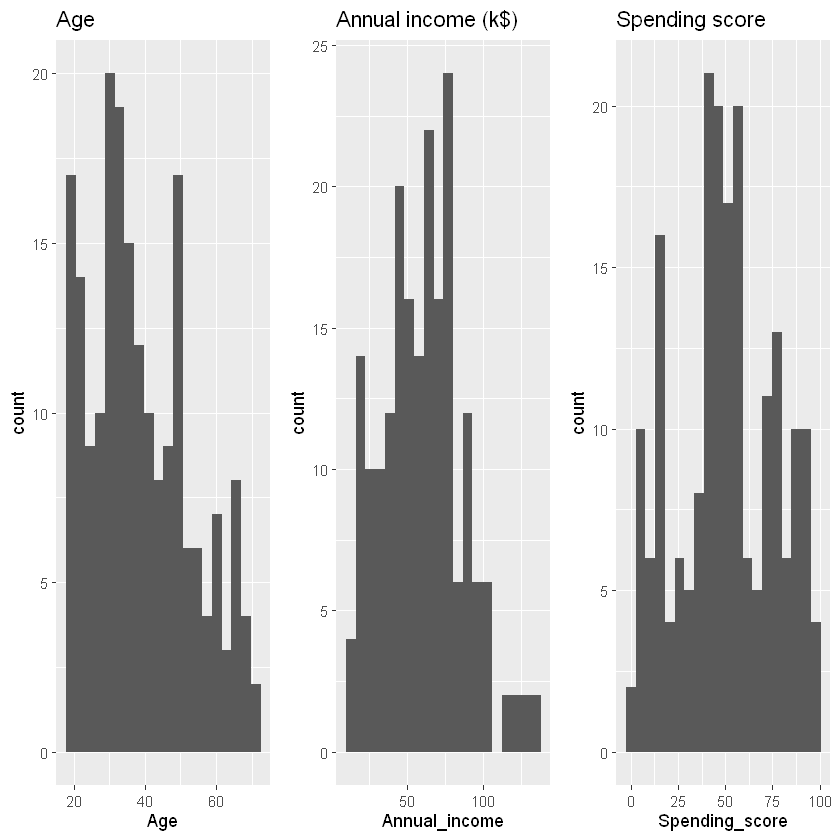

In [23]:
# Combining histograms as a single image
grid.arrange(p1, p2, p3, ncol=3)

We can see some normal distribution in each variable, but age and annual income have more values at the lower end

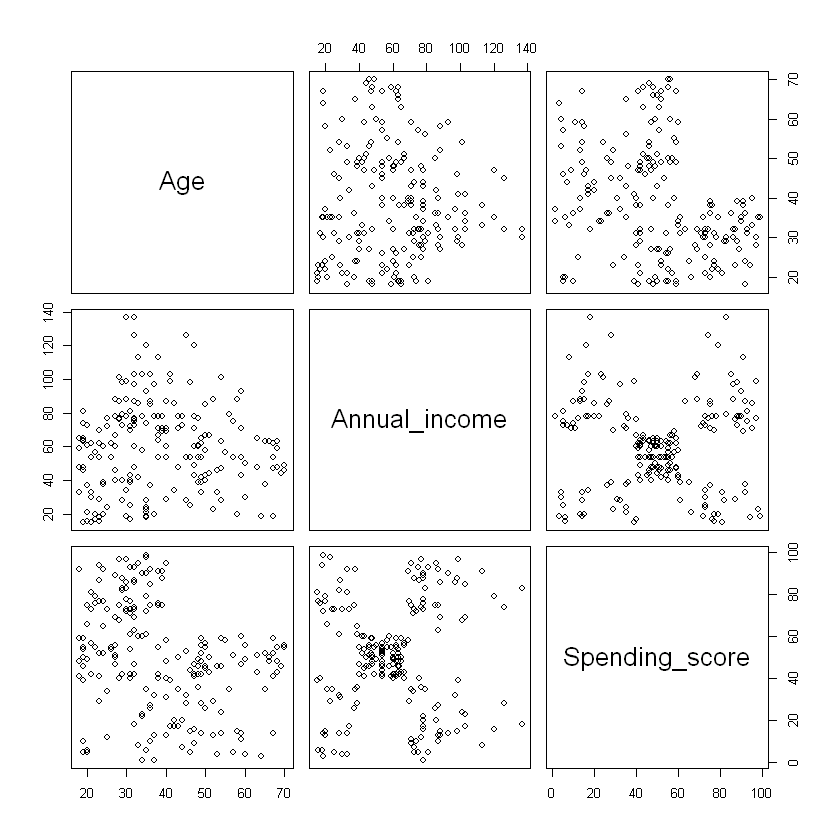

In [24]:
# Scatter plots in pairs
pairs(clust_data) 

Some clustering can be seen in the plots between annual income and spending score

## Correlation analysis

In [25]:
# Creating a correlation matrix
cor_matrix <- cor(clust_data[,])

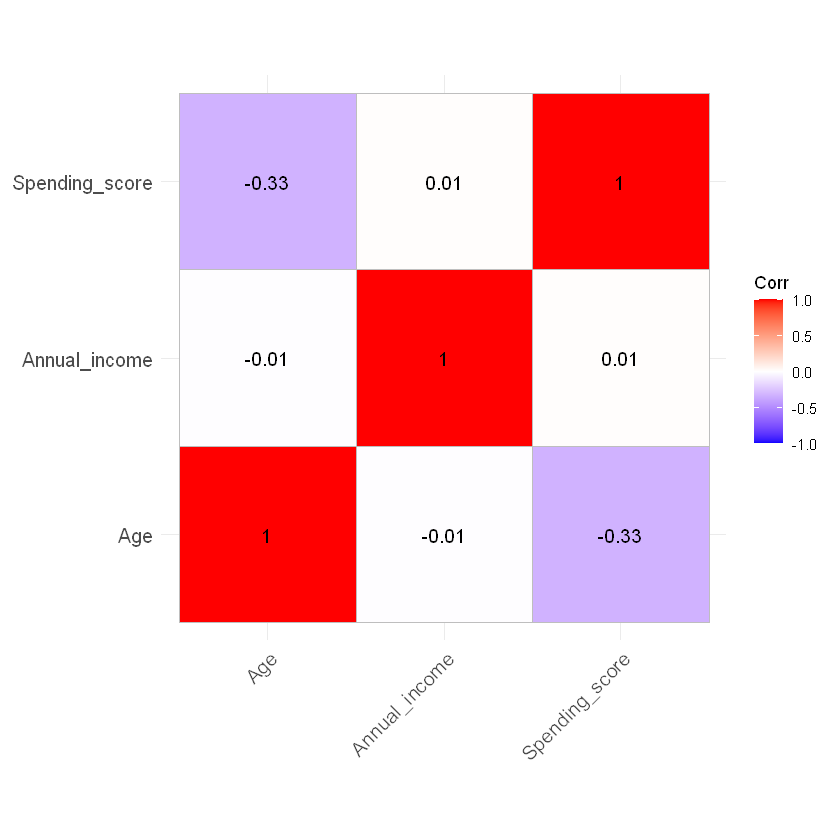

In [26]:
# Creating a visualization of correlations using ggcorrplot
ggcorrplot(cor_matrix, lab = TRUE)

The correlation matrix shows weak or negligible relationships among the variables, with the strongest being a weak negative correlation between Age and Spending Score (-0.33), suggesting older customers may spend slightly less. All other correlations are too small to indicate significant relationships.

## Data normalization

In [27]:
normalized_clust_data <- as.data.frame(apply(clust_data, 2, function(x) (x - min(x)) / (max(x) - min(x))))

## Finding the optimal number of clusters

Using four different methods: 
1. Elbow method
2. Silhopuette method
3. Calinski-Harabasz Index
4. Gap statistic

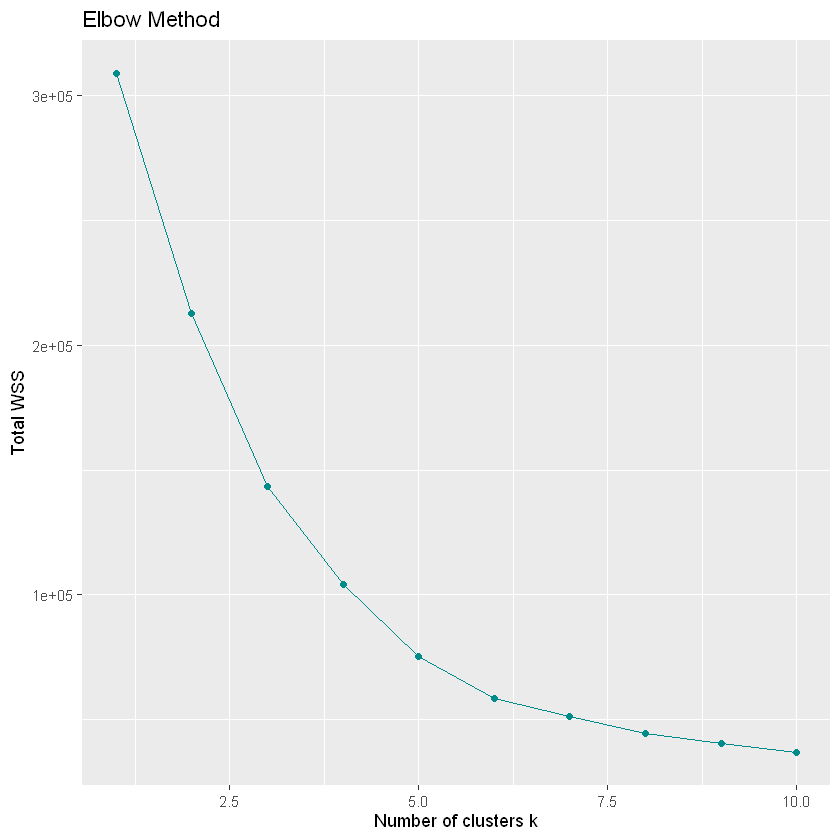

In [40]:
# Elbow Method
tot_within_ss = map_dbl(1:10, function(k) {
  model = kmeans(clust_data, centers=k, nstart = 25)
  model$tot.withinss
})
elbow_plot = ggplot(mapping = aes(x = 1:10, y = tot_within_ss)) +
  geom_line(color = "darkcyan") +
  geom_point(color = "darkcyan") +
  labs(title = "Elbow Method", x = "Number of clusters k", y = "Total WSS")
elbow_plot

In [41]:
# Silhouette Method
sil_widths = map_dbl(2:10, function(k) {
  clus = kmeans(clust_data, centers = k, nstart = 25)
  cs = cluster.stats(d = dist(clust_data), clustering = clus$cluster)
  cs$avg.silwidth
})
sil_plot = ggplot(mapping = aes(x = 2:10, y = sil_widths)) +
  geom_line(color = "green") +
  geom_point(color = "green") +
  labs(title = "Silhouette Method", x = "Number of clusters k", y = "Average Silhouette Width")

In [42]:
# Calinski-Harabasz Index Method
ch_values = map_dbl(2:10, function(k) {
  clus = kmeans(clust_data, centers = k, nstart = 25)
  cs = cluster.stats(d = dist(clust_data), clustering = clus$cluster)
  cs$ch
})
ch_plot = ggplot(mapping = aes(x = 2:10, y = ch_values)) +
  geom_line(color = "orange") +
  geom_point(color = "orange") +
  labs(title = "Calinski-Harabasz Index Method", x = "Number of clusters k", y = "Calinski-Harabasz Index")

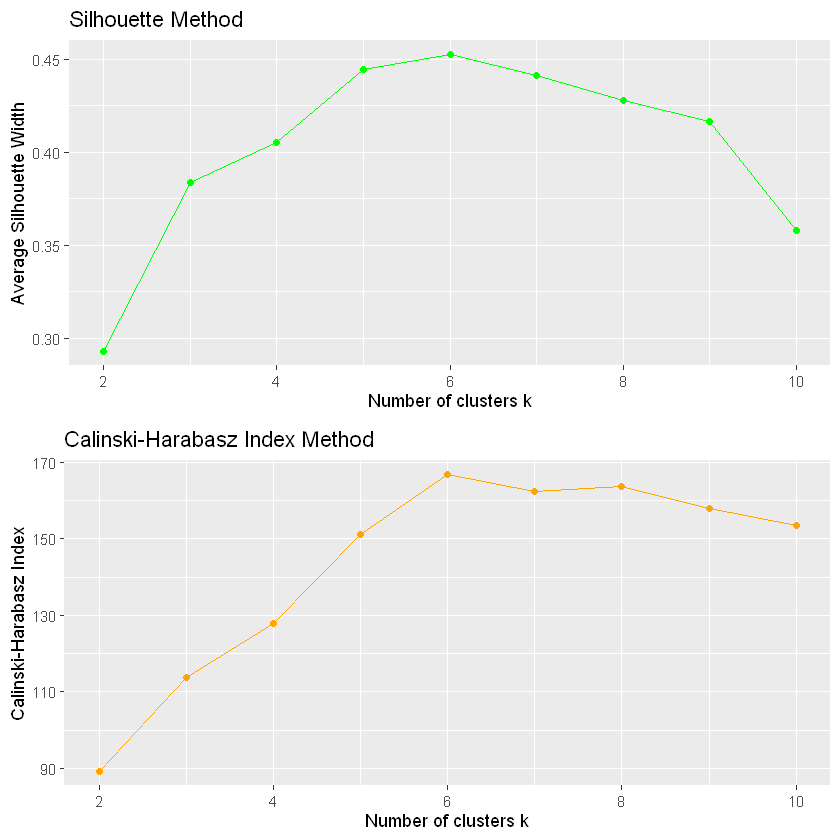

In [43]:
# Creating joint display of plots
grid.arrange(sil_plot, ch_plot, ncol = 1)

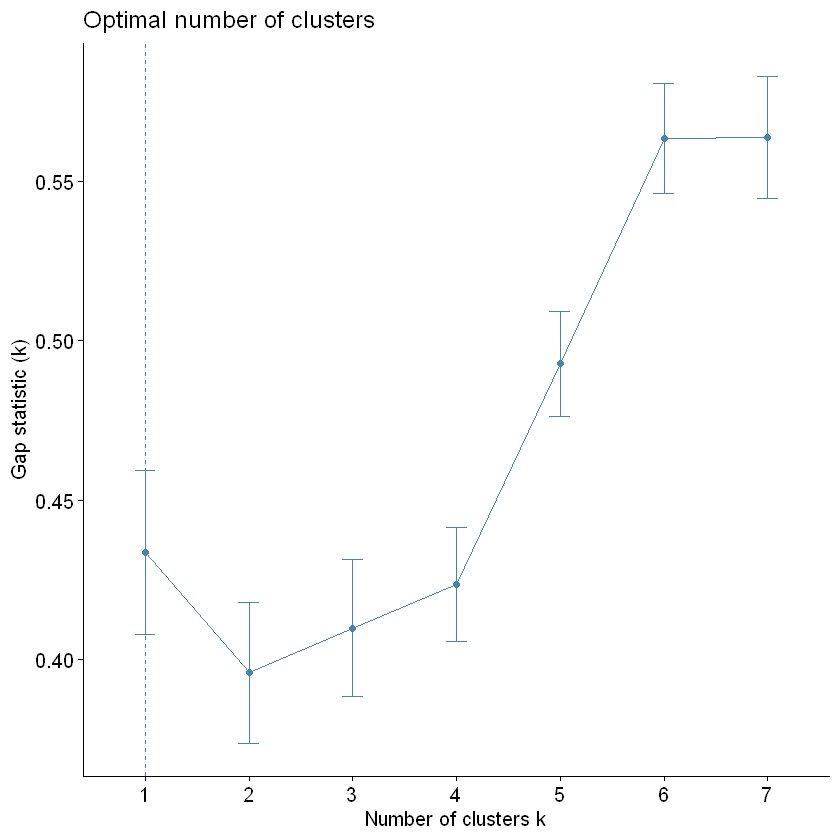

In [46]:
# Gap Statistic
set.seed(123)
gap_stat = clusGap(clust_data, FUN = kmeans, nstart = 25, iter.max = 50, K.max = 7, B = 50)
fviz_gap_stat(gap_stat)

Considering all 4 methods the optimal number of clusters seems to be 6

## K-means clustering with optimal number of clusters (k=6)

In [47]:
# Number of clusters
k <- 6

In [48]:
# Set seed for reproducibility
set.seed(123)

In [49]:
# Perform K-means clustering with multiple initializations (nstart = 25)
kmeans_model <- kmeans(normalized_clust_data, centers = k, nstart = 25)

In [50]:
# Display the structure of the K-means model
str(kmeans_model)

List of 9
 $ cluster     : int [1:200] 6 3 6 3 6 3 1 3 1 3 ...
 $ centers     : num [1:6, 1:3] 0.57 0.737 0.145 0.5 0.286 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:6] "1" "2" "3" "4" ...
  .. ..$ : chr [1:3] "Age" "Annual_income" "Spending_score"
 $ totss       : num 37.4
 $ withinss    : num [1:6] 0.999 1.583 0.593 1.553 1.32 ...
 $ tot.withinss: num 8.39
 $ betweenss   : num 29
 $ size        : int [1:6] 19 45 23 30 40 43
 $ iter        : int 5
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [51]:
# Show the number of data points in each cluster
table(kmeans_model$cluster)


 1  2  3  4  5  6 
19 45 23 30 40 43 

## Visualization of the clusters

In [53]:
# PCA for dimensionality reduction
pca_result <- prcomp(normalized_clust_data, scale = TRUE)  # PCA with scaling

In [54]:
# Create a distance matrix from the original data
dist_matrix <- dist(normalized_clust_data)

In [55]:
# Get the proportion of variance explained by the first two components
var_exp <- summary(pca_result)$importance[2, 1:2]  # Proportion of variance explained by PC1 and PC2
var_dec <- sum(var_exp)  # Cumulative variance explained by PC1 and PC2

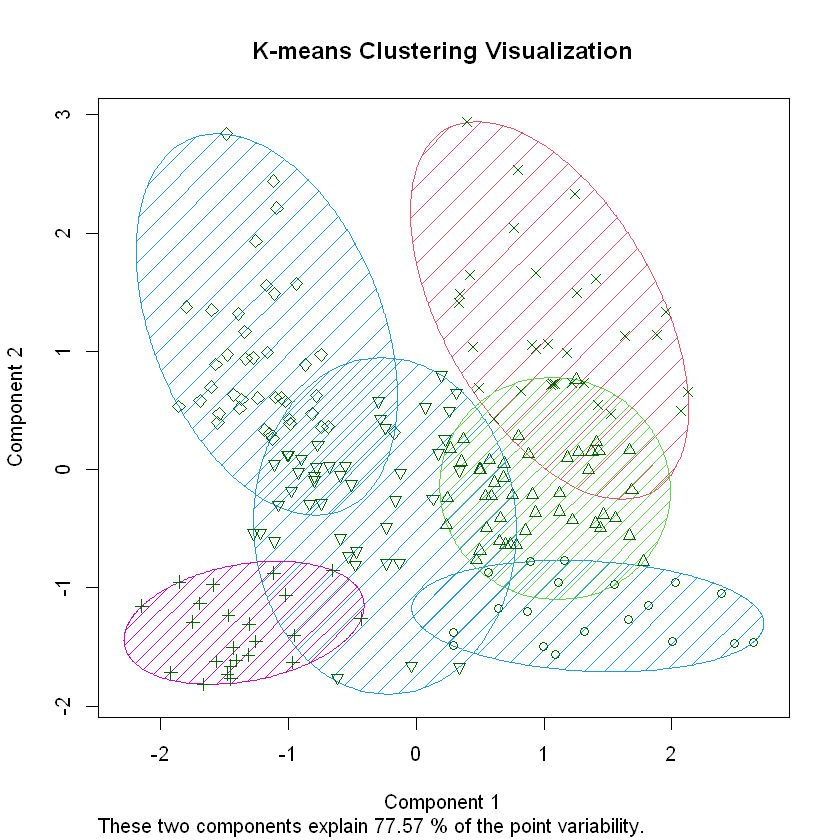

In [56]:
# Create the `clusplot` visualization
clusplot(pca_result$x, 
         clus = kmeans_model$cluster,  # Cluster assignments
         color = TRUE,                  # Color the points by cluster
         shade = TRUE,                  # Shade the clusters
         labels = 0,                    # Do not label individual points
         main = "K-means Clustering Visualization", 
         lines = 0,                     # Do not draw lines between points and centroids
         s.x.2d = list(x = pca_result$x[, 1:2],  # First two components
                       labs = rownames(normalized_clust_data),  # Labels for the data points
                       var.dec = var_exp),  # Variance explained by PC1 and PC2
         sub = paste("These two components explain", 
                     round(100 * var_dec, 2), "% of the point variability.")  # Correct subtitle
)

## Centroids of the clusters

In [57]:
# the cluster centroids are now in normalized form, so we have to denormalize them
kmeans_model$centers

,Age,Annual_income,Spending_score
1,0.5698381,0.10094909,0.1836735
2,0.7371795,0.32185792,0.4904762
3,0.1446488,0.09265859,0.7914818
4,0.5000000,0.61584699,0.1727891
5,0.2860577,0.58278689,0.8216837
6,0.1493739,0.33415936,0.4323683


In [59]:
# Get min and max values for each feature from the original data
age_min <- min(mall_customers$Age)
age_max <- max(mall_customers$Age)
income_min <- min(mall_customers$Annual_income)
income_max <- max(mall_customers$Annual_income)
spending_min <- min(mall_customers$Spending_score)
spending_max <- max(mall_customers$Spending_score)

In [60]:
# Denormalize the cluster centers
denormalized_centers <- kmeans_model$centers

# Apply denormalization formula for each feature (Age, Annual Income, Spending Score)
denormalized_centers[, "Age"] <- denormalized_centers[, "Age"] * (age_max - age_min) + age_min
denormalized_centers[, "Annual_income"] <- denormalized_centers[, "Annual_income"] * (income_max - income_min) + income_min
denormalized_centers[, "Spending_score"] <- denormalized_centers[, "Spending_score"] * (spending_max - spending_min) + spending_min

In [61]:
# Print the denormalized cluster centers 
print(denormalized_centers)

       Age Annual_income Spending_score
1 47.63158      27.31579       19.00000
2 56.33333      54.26667       49.06667
3 25.52174      26.30435       78.56522
4 44.00000      90.13333       17.93333
5 32.87500      86.10000       81.52500
6 25.76744      55.76744       43.37209


The clusters represent a range of customer profiles, from younger individuals with low income and low spending scores, to older individuals with higher income and more varied spending behaviors, including both high spenders with moderate incomes and low spenders with high incomes.